In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import linear_model

## https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
## https://medium.com/data-hackers/implementando-regress%C3%A3o-linear-simples-em-python-91df53b920a8
import statsmodels.api as sm

import math

In [2]:
dftrain = pd.read_csv('.\\testfiles\\train.csv')
dftest = pd.read_csv('.\\testfiles\\test.csv')

#dftrain = dftrain[dftrain['CO_PROVA_MT'] != '2d22ac1d42e6187f09ee6c578df187a760123ccf']
#dftrain.head()

In [3]:
print(list(dftest.columns))
print('Columns test: '+str(len(dftest.columns)))

['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047']
Columns test: 47


In [4]:
def correlations_plot(dataframe, corr_columns):
    dfcorr = dataframe.loc[:, corr_columns]
    corr = dfcorr.corr()

    plt.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar()
    plt.show()

def classificationTP_SEXO(dataframe):
    dataframe['TP_SEXO'] = dataframe['TP_SEXO'].apply(lambda c: 1 if c == 'M' else 2)

def classificationCO_PROVA_MT(dataframe):
    column_class = list(dataframe.CO_PROVA_MT.unique())
    dataframe['CO_PROVA_MT_CLASS'] = dataframe['CO_PROVA_MT'].apply(lambda x: column_class.index(x)+1)
    
def classificationCO_PROVA(dataframe, base, column):
    new_dataframe = dataframe[[base, column]].copy()
    new_dataframe = new_dataframe.sort_values(by=[column])
    
    dfresult = pd.DataFrame()
    dfresult['KEY'] = new_dataframe[column].unique()
    dfresult['MEAN'] = list(new_dataframe.groupby(column)[base].mean())
    dfresult.MEAN.fillna(0, inplace=True)
    
    column_class = list(dfresult['KEY'].unique())

    dataframe[column+'_CLASS'] = dataframe[column].apply(lambda x: column_class.index(x)+1)
    
def classification(x):
    if x == 'A':
        return 1
    elif x == 'B':
        return 2
    elif x == 'C':
        return 3
    elif x == 'D':
        return 4
    elif x == 'E':
        return 5
    elif x == 'F':
        return 6
    elif x == 'G':
        return 7
    elif x == 'H':
        return 8
    elif x == 'I':
        return 9
    elif x == 'J':
        return 10
    elif x == 'K':
        return 11
    elif x == 'L':
        return 12
    elif x == 'M':
        return 13
    elif x == 'N':
        return 14
    elif x == 'O':
        return 15
    elif x == 'P':
        return 16
    elif x == 'Q':
        return 17
    
    return 0
    
def fillNU_NOTA_MT(dataframe):
    dataframe['TP_PRESENCA_MT'] = dataframe['TP_PRESENCA_LC']
    for idx in range(len(dataframe)):
        if dataframe['TP_PRESENCA_MT'][idx] != 1:
            dataframe.iloc[idx, dataframe.columns.get_loc('TP_PRESENCA_MT')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_MT')] = 0
            
    dataframe.NU_NOTA_MT.fillna(dataframe.NU_NOTA_MT.mean(), inplace=True)
    
def fillTP_DEPENDENCIA_ADM_ESC(dataframe):
    for idx in range(len(dataframe)):
        if math.isnan(dataframe['TP_DEPENDENCIA_ADM_ESC'][idx]):
            if dataframe['TP_ESCOLA'][idx] == 1 and (dataframe['Q047'][idx] == 'D' or dataframe['Q047'][idx] == 'E'):
                dataframe.iloc[idx, dataframe.columns.get_loc('TP_DEPENDENCIA_ADM_ESC')] = 4
            elif dataframe['TP_ESCOLA'][idx] == 1 and (dataframe['Q047'][idx] != 'D' and dataframe['Q047'][idx] != 'E'):
                dataframe.iloc[idx, dataframe.columns.get_loc('TP_DEPENDENCIA_ADM_ESC')] = 2
            elif dataframe['TP_ESCOLA'][idx] == 4:
                dataframe.iloc[idx, dataframe.columns.get_loc('TP_DEPENDENCIA_ADM_ESC')] = 4
                
    dataframe.TP_DEPENDENCIA_ADM_ESC.fillna(dataframe.TP_DEPENDENCIA_ADM_ESC.mode(), inplace=True)

def fillTP_STATUS_REDACAO(dataframe):
    for idx in range(len(dataframe)):
        if math.isnan(dataframe['TP_STATUS_REDACAO'][idx]):
                if dataframe['NU_NOTA_REDACAO'][idx] > 0:
                    dataframe.iloc[idx, dataframe.columns.get_loc('TP_STATUS_REDACAO')] = 1
                else:
                    dataframe.iloc[idx, dataframe.columns.get_loc('TP_STATUS_REDACAO')] = 4
                    
def clear_data(dataframe, dfcolumns):
    new_dataFrame = pd.DataFrame()
    
    new_dataFrame = dataframe[dfcolumns].copy()
    
    return new_dataFrame

def preprocess_data_corr(dataframe):
    for idx in range(len(dataframe)):
        if dataframe['TP_PRESENCA_LC'][idx] != 1:
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_LC')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('TP_PRESENCA_LC')] = 0
            
        if dataframe['TP_PRESENCA_CN'][idx] != 1:
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_CN')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('TP_PRESENCA_CN')] = 0
            
        if dataframe['TP_PRESENCA_CH'][idx] != 1:
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_CH')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('TP_PRESENCA_CH')] = 0
        
            
        if dataframe['TP_STATUS_REDACAO'][idx] != 1:
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_REDACAO')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_COMP1')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_COMP2')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_COMP3')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_COMP4')] = 0
            dataframe.iloc[idx, dataframe.columns.get_loc('NU_NOTA_COMP5')] = 0
            
            
def preprocess_data(dataframe):    
    dataframe['NU_NOTA_CN'] = dataframe.NU_NOTA_CN.fillna(dataframe.NU_NOTA_CN.mean())
    dataframe['NU_NOTA_CH'] = dataframe.NU_NOTA_CH.fillna(dataframe.NU_NOTA_CH.mean())
    dataframe['NU_NOTA_LC'] = dataframe.NU_NOTA_LC.fillna(dataframe.NU_NOTA_LC.mean())
    dataframe['NU_NOTA_REDACAO'] = dataframe.NU_NOTA_REDACAO.fillna(dataframe.NU_NOTA_REDACAO.mean())
    
    
    dataframe['Q001'] = dataframe['Q001'].apply(lambda c: classification(c))
    dataframe['Q002'] = dataframe['Q002'].apply(lambda c: classification(c))
    dataframe['Q006'] = dataframe['Q006'].apply(lambda c: classification(c))
    dataframe['Q024'] = dataframe['Q024'].apply(lambda c: classification(c))
    dataframe['Q025'] = dataframe['Q025'].apply(lambda c: classification(c))
    dataframe['Q026'] = dataframe['Q026'].apply(lambda c: classification(c))
    dataframe['Q047'] = dataframe['Q047'].apply(lambda c: classification(c))
    
    #dataframe['NU_NOTA_CN_MEDIA'] = 0
    #for i in cdf.SG_UF_RESIDENCIA.unique():
        #dataframe.loc[dataframe['SG_UF_RESIDENCIA'] == i, 'NU_NOTA_CN_MEDIA'] = dataframe.loc[dataframe['SG_UF_RESIDENCIA'] == i, 'NU_NOTA_CN_MEDIA']

def stats_regression(dataframe):
    regr = sm.OLS(train_label, train_data).fit()
    print(regr.summary())
    p = regr.predict(dataframe)
    return pd.DataFrame(p, columns=['NU_NOTA_MT'])

def scikitlearn_regression(dataframe):
    regr = linear_model.LinearRegression()
    
    scores = cross_val_score(regr, X, y, cv=5)
    print('Cross validation score: ', scores.mean())
    
    # Train the model using the training sets
    regr.fit(train_data, train_label)
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # Make predictions using the testing set
    p = regr.predict(dataframe)
    return pd.DataFrame(p, columns=['NU_NOTA_MT'])

def statistic(pred):
    # The mean squared error
    print("Mean squared error: %.2f"% mean_squared_error(test_label, pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(test_label, pred))
    for i in range(10):
        print(str(test_label.iloc[i])+' '+str(pred.NU_NOTA_MT.iloc[i]))


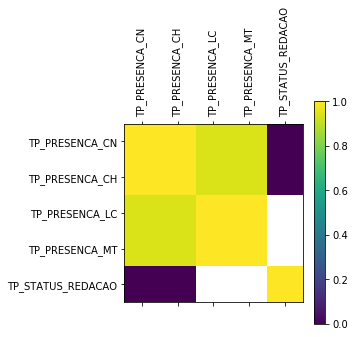

In [5]:
correlations_plot(dftrain, ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_STATUS_REDACAO'])

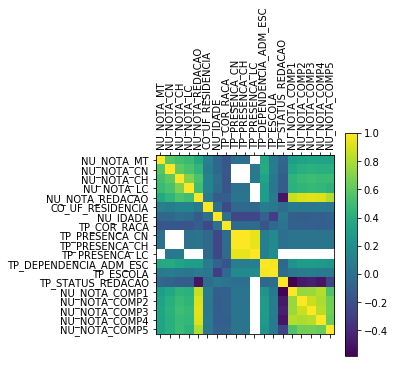

In [6]:
correlations_plot(dftrain, ['NU_NOTA_MT','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC','NU_NOTA_REDACAO',
                        'CO_UF_RESIDENCIA','NU_IDADE', 'TP_SEXO', 'TP_COR_RACA','TP_PRESENCA_CN', 'TP_PRESENCA_CH', 
                        'TP_PRESENCA_LC','TP_DEPENDENCIA_ADM_ESC', 'TP_ESCOLA','TP_STATUS_REDACAO',
                        'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047',
                       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5','CO_PROVA_MT'])

In [7]:
classificationTP_SEXO(dftrain)
classificationCO_PROVA_MT(dftrain)
classificationCO_PROVA(dftrain, 'NU_NOTA_LC', 'CO_PROVA_LC')
classificationCO_PROVA(dftrain, 'NU_NOTA_CN', 'CO_PROVA_CN')
classificationCO_PROVA(dftrain, 'NU_NOTA_CH', 'CO_PROVA_CH')
fillNU_NOTA_MT(dftrain)
fillTP_DEPENDENCIA_ADM_ESC(dftrain)
preprocess_data_corr(dftrain)
fillTP_STATUS_REDACAO(dftrain)
preprocess_data(dftrain)

cdf = dftrain.dropna(subset=['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO'])
#cdf = dftrain.dropna()

print(list(cdf.columns))


['Unnamed: 0', 'NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'CO_MUNICIPIO_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_

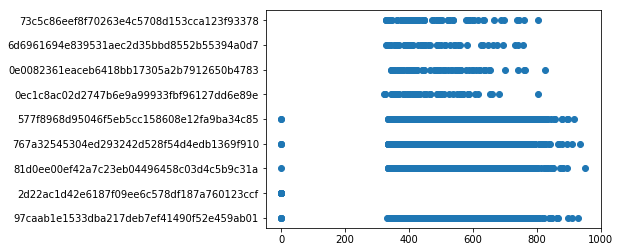

In [8]:
plt.scatter(cdf.NU_NOTA_MT, cdf.CO_PROVA_MT)
plt.show()

#dftrain = dftrain[dftrain['CO_PROVA_MT'] != '2d22ac1d42e6187f09ee6c578df187a760123ccf']

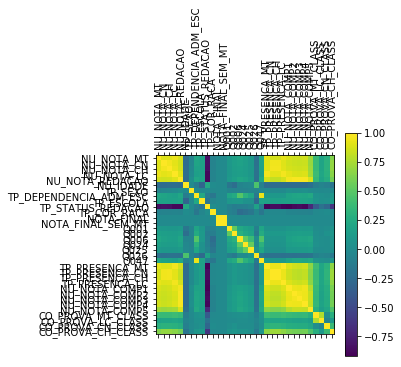

In [9]:
def nota_final(dataframe):
    for idx in range(len(dataframe)):
        dataframe['NOTA_FINAL'] = dataframe.iloc[idx][['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 
                                                       'NU_NOTA_LC', 'NU_NOTA_REDACAO']].mean()
        dataframe['NOTA_FINAL_SEM_MT'] = dataframe.iloc[idx][['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                                                              'NU_NOTA_REDACAO']].mean()
        
nota_final(dftrain)
correlations_plot(dftrain, ['NU_NOTA_MT','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC','NU_NOTA_REDACAO',
                            'NU_IDADE', 'TP_SEXO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ESCOLA','TP_STATUS_REDACAO',
                            'TP_COR_RACA', 'NOTA_FINAL', 'NOTA_FINAL_SEM_MT', 
                            'Q001','Q002','Q006','Q024','Q025','Q026','Q047',
                            'TP_PRESENCA_MT','TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
                            'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
                            'CO_PROVA_MT_CLASS','CO_PROVA_LC_CLASS', 'CO_PROVA_CN_CLASS', 'CO_PROVA_CH_CLASS'])

In [10]:
'''
from itertools import combinations 
  
array = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']
lista = []
for i in range(1, len(array)+1):
    comb = combinations(array, i)
    for j in list(comb):
        lista.append(list(j))

for XFeatures in lista:
    X = cdf[XFeatures]
    y = cdf['NU_NOTA_MT']

    train_data, test_data, train_label, test_label = train_test_split(X, y) # 75% para treino e 25% para teste

    pred = scikitlearn_regression(test_data)
'''

"\nfrom itertools import combinations \n  \narray = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']\nlista = []\nfor i in range(1, len(array)+1):\n    comb = combinations(array, i)\n    for j in list(comb):\n        lista.append(list(j))\n\nfor XFeatures in lista:\n    X = cdf[XFeatures]\n    y = cdf['NU_NOTA_MT']\n\n    train_data, test_data, train_label, test_label = train_test_split(X, y) # 75% para treino e 25% para teste\n\n    pred = scikitlearn_regression(test_data)\n"

In [11]:
XFeatures = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO'] #0.9025009893029038

#XFeatures = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_SEXO', 'NU_IDADE', 'TP_STATUS_REDACAO',
#             'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC', 
#             'Q026', 'Q006'] #4201.61 0.9193087377090622


XFeatures = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 
             'TP_SEXO', 'NU_IDADE','TP_PRESENCA_CN','TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_DEPENDENCIA_ADM_ESC', 
             'Q026', 'Q006'] #0.9191937120507208 4208.25

X = cdf[XFeatures]
y = cdf['NU_NOTA_MT']

train_data, test_data, train_label, test_label = train_test_split(X, y, shuffle=False) # 75% para treino e 25% para teste

pred = scikitlearn_regression(test_data)

statistic(pred)

Cross validation score:  0.9191937120507208
Coefficients: 
 [ 4.45478418e-01  1.95247800e-01  2.21168412e-01  2.75086468e-02
 -1.94709669e+01 -2.65255926e-01 -1.49596324e+02 -1.49596324e+02
  3.34331067e+02  8.45130625e+00  5.15979897e-01  3.35393827e+00]
Mean squared error: 4208.25
Variance score: 0.92
0.0 10.03545178706491
365.4 438.85664618113066
0.0 -15.412948771750163
0.0 -12.760389509102144
368.5 457.66756022617693
482.6 500.07146822361113
431.6 399.55104689931
0.0 -1.666614912924862
452.2 535.8747768664844
540.0 558.8437975415582


In [12]:
result = dftrain[['TP_ESCOLA','TP_DEPENDENCIA_ADM_ESC', 'Q006', 'Q047']]

#rnotnan = result[(result.TP_ESCOLA.notnull()) & (result.TP_DEPENDENCIA_ADM_ESC.notnull()) 
#                 & (result.Q047.notnull())]

## Se a tp_escola for 2 e Q047 for diferente de 'A' entao TP_DEPENDENCIA_ADM_ESC e 2
#rnotnan[(rnotnan['TP_ESCOLA'] == 2) & (rnotnan['Q047'] != 'A') & (rnotnan['TP_DEPENDENCIA_ADM_ESC'] != 2)]

## Inconclusivo - nao ha dados
#rnotnan[(rnotnan['TP_ESCOLA'] == 1)]

## Inconclusivo - nao ha dados
#rnotnan[(rnotnan['TP_ESCOLA'] == 4)]+

rnan = result[result.isna().any(axis=1)]

## Se TP_ESCOLA igual a 1 e Q047 pertece = (D,E) entao TP_DEPENDENCIA_ADM_ESC = 4 e TP_ESCOLA = 3
#rnan[(rnan['TP_ESCOLA'] == 1) & ((rnan['Q047'] == 'D') | (rnan['Q047'] == 'E'))]

## Se TP_ESCOLA igual a 1 e Q047 nao pertece = (D,E) entao TP_DEPENDENCIA_ADM_ESC = 2 e TP_ESCOLA = 2
#rnan[(rnan['TP_ESCOLA'] == 1) & ((rnan['Q047'] != 'D') & (rnan['Q047'] != 'E'))]


## Se TP_ESCOLA igual a 4 entao TP_DEPENDENCIA_ADM_ES = 4
#rnan[(rnan['TP_ESCOLA'] == 4)]

rnan.head()

,TP_ESCOLA,TP_DEPENDENCIA_ADM_ESC,Q006,Q047


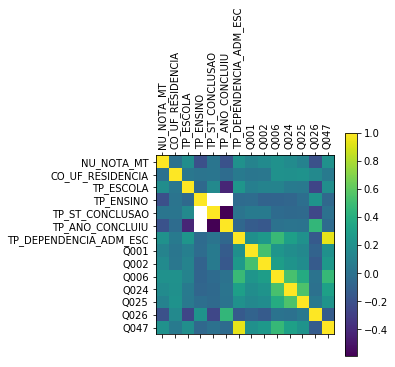

In [13]:
correlations_plot(cdf, ['NU_NOTA_MT', 'CO_UF_RESIDENCIA','SG_UF_RESIDENCIA', 'TP_ESCOLA', 'TP_ENSINO', 'TP_ST_CONCLUSAO', 
                        'TP_ANO_CONCLUIU','TP_DEPENDENCIA_ADM_ESC','Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027',
                        'Q047'])

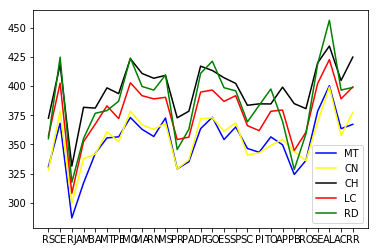

In [14]:
## Visualizar a media por estado
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_MT'].mean(), c='blue', label='MT')
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_CN'].mean(), c='yellow', label='CN')
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_CH'].mean(), c='black', label='CH')
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_LC'].mean(), c='red', label='LC')
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_REDACAO'].mean(), c='green', label='RD')
plt.legend()
plt.show()

In [15]:
'''
dfagguf = cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_MT'].mean()
dfaggufrd = cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_REDACAO'].mean()
dfaggufmt = pd.DataFrame()
dfaggufmt['SG_UF_RESIDENCIA'] = cdf.sort_values(by='SG_UF_RESIDENCIA').SG_UF_RESIDENCIA.unique()
dfaggufmt['NU_MEDIA_UF_MT'] = list(dfagguf)
dfaggufmt['NU_MEDIA_UF_RD'] = list(dfaggufrd)
dfaggufmt['NU_MEDIA_UF_DF'] = dfaggufmt['NU_MEDIA_UF_MT']-dfaggufmt['NU_MEDIA_UF_RD']

cdf['NU_MEDIA_UF_RD'] = 0
for i in range(len(cdf)):
    Media = dfaggufmt[dfaggufmt['SG_UF_RESIDENCIA']==cdf.iloc[i,cdf.columns.get_loc('SG_UF_RESIDENCIA')]].NU_MEDIA_UF_RD
    cdf.iloc[i, cdf.columns.get_loc('NU_MEDIA_UF_RD')] = float(Media)

cdf.head()
'''
dfagguf = cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_MT'].mean()
dfaggufrd = cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_CN'].mean()
dfaggufmt = pd.DataFrame()
dfaggufmt['SG_UF_RESIDENCIA'] = cdf.sort_values(by='SG_UF_RESIDENCIA').SG_UF_RESIDENCIA.unique()
dfaggufmt['NU_MEDIA_UF_MT'] = list(dfagguf)
dfaggufmt['NU_MEDIA_UF_CN'] = list(dfaggufrd)
dfaggufmt['NU_MEDIA_UF_DF'] = dfaggufmt['NU_MEDIA_UF_MT']-dfaggufmt['NU_MEDIA_UF_CN']

cdf['NU_MEDIA_UF_CN'] = 0
for i in range(len(cdf)):
    Media = dfaggufmt[dfaggufmt['SG_UF_RESIDENCIA']==cdf.iloc[i,cdf.columns.get_loc('SG_UF_RESIDENCIA')]].NU_MEDIA_UF_CN
    cdf.iloc[i, cdf.columns.get_loc('NU_MEDIA_UF_CN')] = float(Media)

cdf.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q046,Q047,Q048,Q049,Q050,CO_PROVA_MT_CLASS,CO_PROVA_LC_CLASS,CO_PROVA_CN_CLASS,CO_PROVA_CH_CLASS,NU_MEDIA_UF_CN
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,1,0.0,...,A,1,A,B,D,1,2,2,6,335.990647
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,2,0.0,...,B,1,A,C,A,1,2,8,4,360.675574
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,2,0.0,...,C,1,A,B,A,2,3,4,2,360.675574
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,2,0.0,...,A,4,A,A,A,2,3,4,2,342.690672
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,1,0.0,...,A,1,A,A,A,2,3,4,2,299.377007


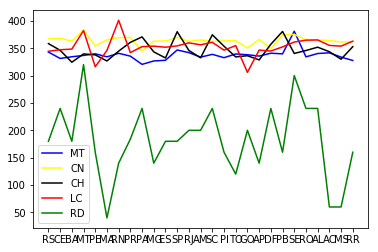

In [16]:
## Visualizar a min por estado
dfmin = cdf.copy()
dfmin = dfmin[dfmin['NU_NOTA_MT']!= 0]
dfmin = dfmin[dfmin['NU_NOTA_CN']!= 0]
dfmin = dfmin[dfmin['NU_NOTA_CH']!= 0]
dfmin = dfmin[dfmin['NU_NOTA_LC']!= 0]
dfmin = dfmin[dfmin['NU_NOTA_REDACAO']!= 0]

plt.plot(dfmin['SG_UF_RESIDENCIA'].unique(), dfmin.groupby('SG_UF_RESIDENCIA')['NU_NOTA_MT'].min(), c='blue', label='MT')
plt.plot(dfmin['SG_UF_RESIDENCIA'].unique(), dfmin.groupby('SG_UF_RESIDENCIA')['NU_NOTA_CN'].min(), c='yellow', label='CN')
plt.plot(dfmin['SG_UF_RESIDENCIA'].unique(), dfmin.groupby('SG_UF_RESIDENCIA')['NU_NOTA_CH'].min(), c='black', label='CH')
plt.plot(dfmin['SG_UF_RESIDENCIA'].unique(), dfmin.groupby('SG_UF_RESIDENCIA')['NU_NOTA_LC'].min(), c='red', label='LC')
plt.plot(dfmin['SG_UF_RESIDENCIA'].unique(), dfmin.groupby('SG_UF_RESIDENCIA')['NU_NOTA_REDACAO'].min(), c='green', label='RD')
plt.legend()
plt.show()

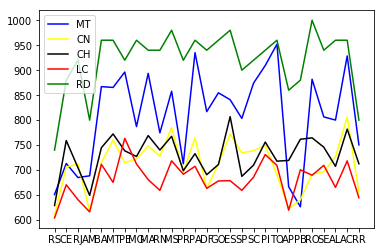

In [17]:
## Visualizar a max por estado
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_MT'].max(), c='blue', label='MT')
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_CN'].max(), c='yellow', label='CN')
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_CH'].max(), c='black', label='CH')
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_LC'].max(), c='red', label='LC')
plt.plot(cdf['SG_UF_RESIDENCIA'].unique(), cdf.groupby('SG_UF_RESIDENCIA')['NU_NOTA_REDACAO'].max(), c='green', label='RD')
plt.legend()
plt.show()

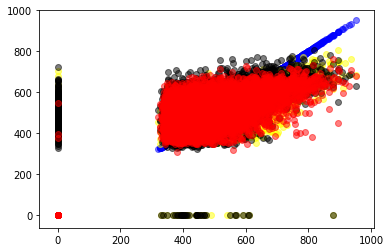

In [18]:
plt.scatter(cdf.NU_NOTA_MT, cdf.NU_NOTA_MT, c='blue', alpha=0.5)
plt.scatter(cdf.NU_NOTA_MT, cdf.NU_NOTA_CN, c='yellow', alpha=0.5)
plt.scatter(cdf.NU_NOTA_MT, cdf.NU_NOTA_CH, c='black', alpha=0.5)
plt.scatter(cdf.NU_NOTA_MT, cdf.NU_NOTA_LC, c='red', alpha=0.5)
#plt.scatter(cdf.NU_NOTA_MT, cdf.NU_NOTA_REDACAO, c='green', alpha=0.5)

plt.show()

320.5
952.0


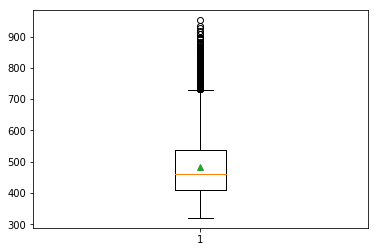

In [19]:
print(cdf[cdf['NU_NOTA_MT']!= 0].NU_NOTA_MT.min())
print(cdf[cdf['NU_NOTA_MT']!= 0].NU_NOTA_MT.max())

plt.boxplot(cdf[cdf['NU_NOTA_MT']!= 0].NU_NOTA_MT, showmeans=True)
plt.show()

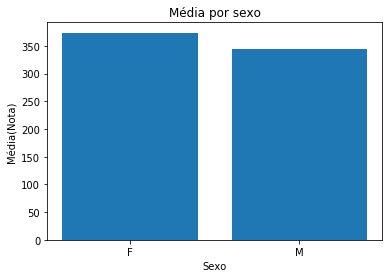

In [20]:
## Visualizar a media por sexo
plt.bar(cdf['TP_SEXO'].unique(), cdf.groupby('TP_SEXO')['NU_NOTA_MT'].mean())
plt.title('Média por sexo')
plt.ylabel('Média(Nota)')
plt.xlabel('Sexo')
plt.xticks(np.arange(start=1, stop=3), ('F', 'M'))
plt.show()

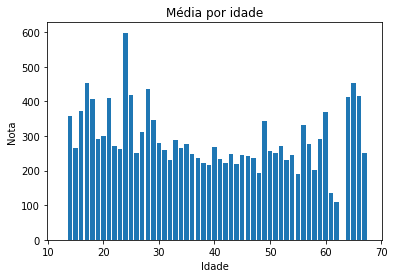

In [21]:
plt.bar(cdf.NU_IDADE.unique(), cdf.groupby('NU_IDADE')['NU_NOTA_MT'].mean())
plt.title('Média por idade')
plt.ylabel('Nota')
plt.xlabel('Idade')
plt.show()

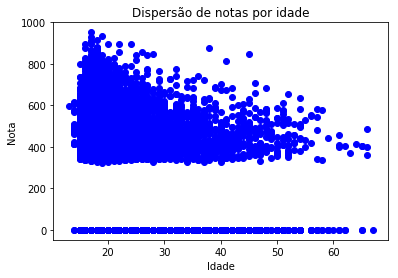

In [22]:
plt.scatter(cdf.NU_IDADE, cdf.NU_NOTA_MT, c='blue')
plt.xlabel('Idade')
plt.ylabel('Nota')
plt.title('Dispersão de notas por idade')
plt.show()

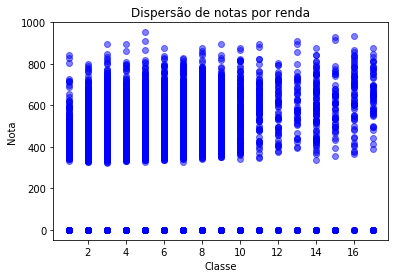

In [23]:
plt.scatter(cdf.Q006, cdf.NU_NOTA_MT, c='blue', alpha=0.5)
plt.xlabel('Classe')
plt.ylabel('Nota')
plt.title('Dispersão de notas por renda')
plt.show()

In [24]:
# Verificando se alguém que não estava presente teve atribuido alguma nota
len(dftrain[(dftrain.TP_PRESENCA_MT!=1) & (dftrain.NU_NOTA_MT.notnull())]) != 0

True

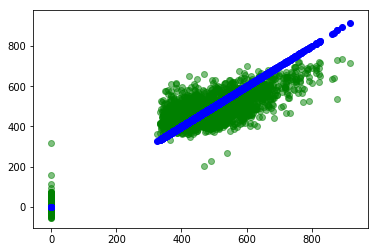

In [25]:
plt.scatter(test_label, pred, c='green', alpha=0.5)
plt.scatter(test_label, test_label, c='blue')
plt.show()

In [30]:
#Resultado
classificationTP_SEXO(dftest)
classificationCO_PROVA(dftest, 'NU_NOTA_LC', 'CO_PROVA_LC')
classificationCO_PROVA(dftest, 'NU_NOTA_CN', 'CO_PROVA_CN')
classificationCO_PROVA(dftest, 'NU_NOTA_CH', 'CO_PROVA_CH')

fillTP_DEPENDENCIA_ADM_ESC(dftest)
preprocess_data_corr(dftest)
fillTP_STATUS_REDACAO(dftest)
preprocess_data(dftest)

result = scikitlearn_regression(dftest[XFeatures])
result[result['NU_NOTA_MT'] < 0] = 0
answer = pd.DataFrame()
answer['NU_INSCRICAO'] = dftest.NU_INSCRICAO
answer['NU_NOTA_MT'] = result.NU_NOTA_MT

answer.to_csv('answer.csv', index= False)

Cross validation score:  0.9191937120507208
Coefficients: 
 [ 4.45478418e-01  1.95247800e-01  2.21168412e-01  2.75086468e-02
 -1.94709669e+01 -2.65255926e-01 -1.49596324e+02 -1.49596324e+02
  3.34331067e+02  8.45130625e+00  5.15979897e-01  3.35393827e+00]
